In [1]:
import librosa
import librosa.display
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,AveragePooling2D,ZeroPadding2D,BatchNormalization

Using TensorFlow backend.


In [9]:
y, sr = librosa.load('/home/daniel/datatest/nine/d8ee4734_nohash_0.wav',sr=16000,duration=10)

In [10]:
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title('Monophonic')

In [11]:
plt.figure(figsize=(12, 8))
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [12]:
plt.subplot(4, 2, 2)
librosa.display.specshow(D, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

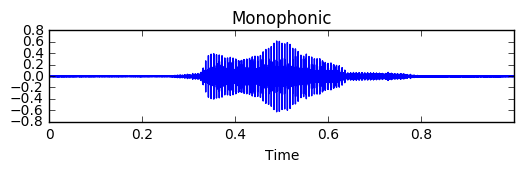

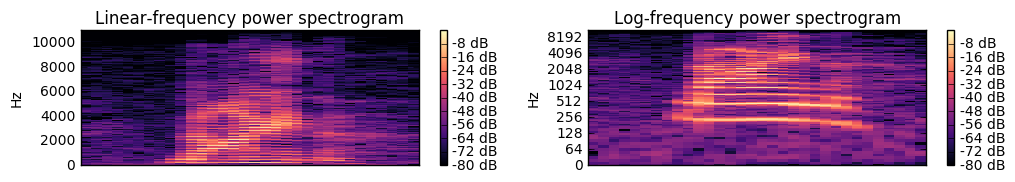

In [13]:
plt.show()

In [14]:
DATA_PATH = "/home/daniel/data/"

In [15]:
hop_length = 320

In [16]:
# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)

In [17]:
import numpy as np
import os

DATA_PATH = "/home/daniel/data/"

# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)


In [18]:
labels, _, _ = get_labels(DATA_PATH)
labels

['marvin',
 'happy',
 'six',
 'up',
 'stop',
 'yes',
 'sheila',
 'zero',
 'dog',
 'right',
 'house',
 'no',
 'two',
 'left',
 'cat',
 'nine',
 'seven',
 'three',
 'wow',
 'bed']

In [77]:
# Handy function to convert wav2mfcc
def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave,hop_length=hop_length, sr=16000,n_mfcc=26,n_fft=int(16000*0.04))

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

In [78]:
def save_data_to_array(path=DATA_PATH, max_len=11):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in wavfiles:
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
        np.save(label + '.npy', mfcc_vectors)

In [79]:
def get_train_test(split_ratio=0.8, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))
        print label
    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)

In [80]:
def prepare_dataset(path=DATA_PATH):
    labels, _, _ = get_labels(path)
    data = {}
    for label in labels:
        data[label] = {}
        data[label]['path'] = [path  + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]

        vectors = []

        for wavfile in data[label]['path']:
            wave, sr = librosa.load(wavfile, mono=True, sr=None)
            # Downsampling
            wave = wave[::3]
            mfcc = librosa.feature.mfcc(wave,hop_length=hop_length, sr=16000,n_mfcc=26,n_fft=int(16000*0.04))
            vectors.append(mfcc)

        data[label]['mfcc'] = vectors

    return data

In [81]:
def load_dataset(path=DATA_PATH):
    data = prepare_dataset(path)

    dataset = []

    for key in data:
        for mfcc in data[key]['mfcc']:
            dataset.append((key, mfcc))

    return dataset[:100]

In [82]:

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Conv1D
from keras.utils import to_categorical

# Second dimension of the feature is dim2
feature_dim_2 = 11

# Save data to array file first
save_data_to_array(max_len=feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
feature_dim_1 = 26
channel = 1
epochs = 25
batch_size = 100
verbose = 1
num_classes = 20

# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

happy
six
up
stop
yes
sheila
zero
dog
right
house
no
two
left
cat
nine
seven
three
wow
bed


In [83]:
# Predicts one sample
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][
            np.argmax(model.predict(sample_reshaped))
    ]

In [84]:
def model_lenet():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(5, 5), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(62, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [85]:
model = model_lenet()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 15s 553us/step - loss: 2.8394 - acc: 0.1394 - val_loss: 2.1519 - val_acc: 0.3162
Epoch 2/25
27200/27200 [==============================] - 12s 442us/step - loss: 1.7974 - acc: 0.4281 - val_loss: 1.5042 - val_acc: 0.5126
Epoch 3/25
27200/27200 [==============================] - 12s 426us/step - loss: 1.3553 - acc: 0.5635 - val_loss: 1.3223 - val_acc: 0.5772
Epoch 4/25
27200/27200 [==============================] - 12s 424us/step - loss: 1.1665 - acc: 0.6269 - val_loss: 1.2431 - val_acc: 0.6012
Epoch 5/25
27200/27200 [==============================] - 11s 421us/step - loss: 1.0373 - acc: 0.6662 - val_loss: 1.2788 - val_acc: 0.6119
Epoch 6/25
27200/27200 [==============================] - 12s 425us/step - loss: 0.9521 - acc: 0.6911 - val_loss: 1.1731 - val_acc: 0.6310
Epoch 7/25
27200/27200 [==============================] - 13s 479us/step - loss: 0.8657 - acc: 0.7180 - val_loss: 1.2

In [97]:
def model_lenet_modk2():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(2, 2), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    #model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(2, 2),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(62, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [98]:
model = model_lenet_modk2()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 10s 353us/step - loss: 4.0546 - acc: 0.0521 - val_loss: 2.9958 - val_acc: 0.0468
Epoch 2/25
27200/27200 [==============================] - 9s 334us/step - loss: 2.9985 - acc: 0.0508 - val_loss: 2.9964 - val_acc: 0.0474
Epoch 3/25
27200/27200 [==============================] - 9s 348us/step - loss: 3.0006 - acc: 0.0481 - val_loss: 2.9962 - val_acc: 0.0466
Epoch 4/25
27200/27200 [==============================] - 8s 303us/step - loss: 2.9972 - acc: 0.0499 - val_loss: 2.9958 - val_acc: 0.0493
Epoch 5/25
27200/27200 [==============================] - 8s 287us/step - loss: 2.9529 - acc: 0.0673 - val_loss: 2.8181 - val_acc: 0.1172
Epoch 6/25
27200/27200 [==============================] - 9s 343us/step - loss: 2.1787 - acc: 0.3148 - val_loss: 1.6685 - val_acc: 0.4604
Epoch 7/25
27200/27200 [==============================] - 9s 338us/step - loss: 1.4602 - acc: 0.5347 - val_loss: 1.3576 - 

In [88]:
def model_lenet_modk3():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(3, 3), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    #model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(3, 3),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(62, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [89]:
model = model_lenet_modk3()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 10s 386us/step - loss: 2.9677 - acc: 0.1163 - val_loss: 2.3158 - val_acc: 0.2612
Epoch 2/25
27200/27200 [==============================] - 9s 344us/step - loss: 2.0527 - acc: 0.3495 - val_loss: 1.6777 - val_acc: 0.4694
Epoch 3/25
27200/27200 [==============================] - 9s 344us/step - loss: 1.5832 - acc: 0.4969 - val_loss: 1.5372 - val_acc: 0.5174
Epoch 4/25
27200/27200 [==============================] - 10s 360us/step - loss: 1.3520 - acc: 0.5644 - val_loss: 1.3362 - val_acc: 0.5791
Epoch 5/25
27200/27200 [==============================] - 9s 348us/step - loss: 1.1975 - acc: 0.6145 - val_loss: 1.2651 - val_acc: 0.5965
Epoch 6/25
27200/27200 [==============================] - 9s 343us/step - loss: 1.0878 - acc: 0.6481 - val_loss: 1.2646 - val_acc: 0.6009
Epoch 7/25
27200/27200 [==============================] - 10s 356us/step - loss: 1.0059 - acc: 0.6744 - val_loss: 1.2589 

In [90]:
def model_lenet_modk4():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(4, 4), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(4, 4),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(62, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [91]:
model = model_lenet_modk4()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 17s 610us/step - loss: 3.3182 - acc: 0.0889 - val_loss: 2.5052 - val_acc: 0.2209
Epoch 2/25
27200/27200 [==============================] - 17s 639us/step - loss: 1.8921 - acc: 0.4115 - val_loss: 1.4406 - val_acc: 0.5535
Epoch 3/25
27200/27200 [==============================] - 16s 606us/step - loss: 1.2103 - acc: 0.6152 - val_loss: 1.1692 - val_acc: 0.6262
Epoch 4/25
27200/27200 [==============================] - 19s 692us/step - loss: 0.9774 - acc: 0.6849 - val_loss: 1.0734 - val_acc: 0.6650
Epoch 5/25
27200/27200 [==============================] - 18s 659us/step - loss: 0.8244 - acc: 0.7350 - val_loss: 1.0283 - val_acc: 0.6834
Epoch 6/25
27200/27200 [==============================] - 16s 588us/step - loss: 0.7063 - acc: 0.7724 - val_loss: 0.9743 - val_acc: 0.7034
Epoch 7/25
27200/27200 [==============================] - 16s 588us/step - loss: 0.6117 - acc: 0.8007 - val_loss: 0.9

In [92]:
def model_lenet_modk6():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(6, 6), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(6, 6),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(62, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [93]:
model = model_lenet_modk6()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 16s 573us/step - loss: 2.6934 - acc: 0.1848 - val_loss: 1.9094 - val_acc: 0.3922
Epoch 2/25
27200/27200 [==============================] - 12s 434us/step - loss: 1.5630 - acc: 0.5053 - val_loss: 1.5164 - val_acc: 0.5306
Epoch 3/25
27200/27200 [==============================] - 11s 411us/step - loss: 1.1650 - acc: 0.6271 - val_loss: 1.2109 - val_acc: 0.6212
Epoch 4/25
27200/27200 [==============================] - 11s 397us/step - loss: 0.9901 - acc: 0.6820 - val_loss: 1.0886 - val_acc: 0.6712
Epoch 5/25
27200/27200 [==============================] - 12s 454us/step - loss: 0.8733 - acc: 0.7191 - val_loss: 0.9835 - val_acc: 0.6960
Epoch 6/25
27200/27200 [==============================] - 11s 393us/step - loss: 0.7807 - acc: 0.7507 - val_loss: 0.9770 - val_acc: 0.7032
Epoch 7/25
27200/27200 [==============================] - 12s 439us/step - loss: 0.7182 - acc: 0.7678 - val_loss: 1.0

In [94]:
print(predict('/home/daniel/datatest/nine/d8ee4734_nohash_0.wav', model=model))

nine


In [95]:
def model_spnet():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(5, 5), activation='relu',strides=4, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5), activation='relu'))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5), strides=1, activation='relu'))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [96]:
model = model_spnet()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 11s 397us/step - loss: 2.7093 - acc: 0.1608 - val_loss: 2.1531 - val_acc: 0.3100
Epoch 2/25
27200/27200 [==============================] - 10s 370us/step - loss: 1.9825 - acc: 0.3611 - val_loss: 1.7791 - val_acc: 0.4246
Epoch 3/25
27200/27200 [==============================] - 10s 379us/step - loss: 1.6924 - acc: 0.4512 - val_loss: 1.6587 - val_acc: 0.4584
Epoch 4/25
27200/27200 [==============================] - 11s 387us/step - loss: 1.5346 - acc: 0.4993 - val_loss: 1.5694 - val_acc: 0.4901
Epoch 5/25
27200/27200 [==============================] - 9s 327us/step - loss: 1.4237 - acc: 0.5356 - val_loss: 1.5039 - val_acc: 0.5066
Epoch 6/25
27200/27200 [==============================] - 8s 294us/step - loss: 1.3485 - acc: 0.5598 - val_loss: 1.4797 - val_acc: 0.5181
Epoch 7/25
27200/27200 [==============================] - 8s 292us/step - loss: 1.2814 - acc: 0.5808 - val_loss: 1.4761

In [68]:
spnet = {}
lenet = {}
lenet_k2 = {}
lenet_k3 = {}
lenet_k4 = {}
lenet_k6 = {}

In [69]:
spnet[1] = 0.1925; spnet[5] = 0.5321; spnet[10] = 0.6224; spnet[15] = 0.6840; spnet[20] = 0.7310; spnet[25] = 0.7716; 

In [70]:
lenet[1] = 0.1035; lenet[5] = 0.6457; lenet[10] = 0.7575; lenet[15] = 0.8428; lenet[20] = 0.9051; lenet[25] = 0.9439; 

In [71]:
lenet_k2[1] = 0.0471; lenet_k2[5] = 0.5822; lenet_k2[10] = 0.7968; lenet_k2[15] = 0.9081; lenet_k2[20] = 0.9652; lenet_k2[25] = 0.9882; 

In [72]:
lenet_k3[1] = 0.1176; lenet_k3[5] = 0.6073; lenet_k3[10] = 0.7173; lenet_k3[15] = 0.7956; lenet_k3[20] = 0.8569; lenet_k3[25] = 0.9057; 

In [73]:
lenet_k4[1] = 0.1103; lenet_k4[5] = 0.7266; lenet_k4[10] = 0.8581; lenet_k4[15] = 0.9350; lenet_k4[20] = 0.9717; lenet_k4[25] = 0.9854; 

In [74]:
lenet_k6[1] = 0.0772; lenet_k6[5] = 0.7003; lenet_k6[10] = 0.8144; lenet_k6[15] = 0.8785; lenet_k6[20] = 0.9266; lenet_k6[25] = 0.9577; 

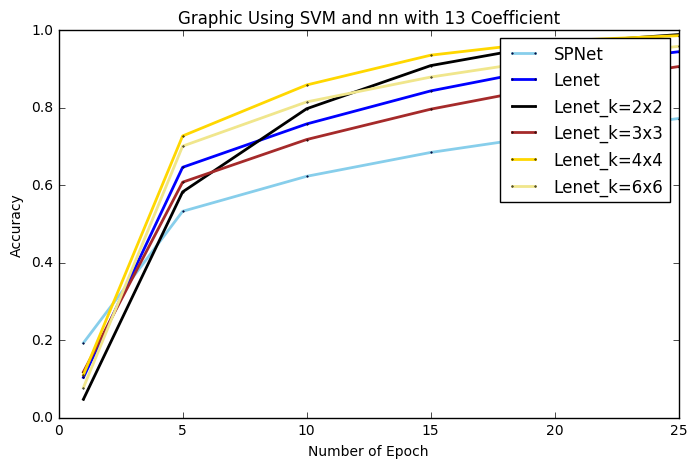

In [75]:
# Data
df=pd.DataFrame({'x': spnet.keys(), 'SPNet': spnet.values(), 'Lenet': lenet.values(), 'Lenet_k=2x2':lenet_k2.values(), 'Lenet_k=3x3':lenet_k3.values(), 'Lenet_k=4x4':lenet_k4.values(), 'Lenet_k=6x6':lenet_k6.values()})
 
# multiple line plot
plt.figure(figsize=(8,5))
plt.plot( 'x', 'SPNet', data=df, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=2)
plt.plot( 'x', 'Lenet', data=df, marker='o', markerfacecolor='blue', markersize=1, color='blue', linewidth=2)
plt.plot( 'x', 'Lenet_k=2x2', data=df, marker='o', markerfacecolor='black', markersize=1, color='black', linewidth=2)
plt.plot( 'x', 'Lenet_k=3x3', data=df, marker='o', markerfacecolor='brown', markersize=1, color='brown', linewidth=2)
plt.plot( 'x', 'Lenet_k=4x4', data=df, marker='o', markerfacecolor='gold', markersize=1, color='gold', linewidth=2)
plt.plot( 'x', 'Lenet_k=6x6', data=df, marker='o', markerfacecolor='khaki', markersize=1, color='khaki', linewidth=2)
plt.title('Graphic Using SVM and nn with 13 Coefficient')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [76]:
tabel_acc20 = pd.DataFrame([spnet.keys(),spnet.values(),lenet.values(),lenet_k2.values(),lenet_k3.values(),lenet_k4.values(),lenet_k6.values()])
tabel_acc20 = tabel_acc20.T
tabel_acc20.columns = ['number of epoch','SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']
tabel_acc20

,number of epoch,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,1.0,0.1925,0.1035,0.0471,0.1176,0.1103,0.0772
1,5.0,0.5321,0.6457,0.5822,0.6073,0.7266,0.7003
2,10.0,0.6224,0.7575,0.7968,0.7173,0.8581,0.8144
3,15.0,0.6840,0.8428,0.9081,0.7956,0.9350,0.8785
4,20.0,0.7310,0.9051,0.9652,0.8569,0.9717,0.9266
5,25.0,0.7716,0.9439,0.9882,0.9057,0.9854,0.9577


In [40]:
spnet13 = {}
lenet13 = {}
lenet13_k2 = {}
lenet13_k3 = {}
lenet13_k4 = {}
lenet13_k6 = {}

In [41]:
spnet13[1] = 0.2054; spnet13[5] = 0.5474; spnet13[10] = 0.6310; spnet13[15] = 0.6905; spnet13[20] = 0.7459; spnet13[25] = 0.7872; 

In [42]:
lenet13[1] = 0.1330; lenet13[5] = 0.6335; lenet13[10] = 0.7281; lenet13[15] = 0.7885; lenet13[20] = 0.8375; lenet13[25] = 0.8782; 

In [43]:
lenet13_k2[1] = 0.1200; lenet13_k2[5] = 0.6473; lenet13_k2[10] = 0.7747; lenet13_k2[15] = 0.8563; lenet13_k2[20] = 0.9197; lenet13_k2[25] = 0.9578; 

In [44]:
lenet13_k3[1] = 0.1149; lenet13_k3[5] = 0.5739; lenet13_k3[10] = 0.6649; lenet13_k3[15] = 0.7171; lenet13_k3[20] = 0.7602; lenet13_k3[25] = 0.7996; 

In [45]:
lenet13_k4[1] = 0.1575; lenet13_k4[5] = 0.7296; lenet13_k4[10] = 0.8484; lenet13_k4[15] = 0.9227; lenet13_k4[20] = 0.9626; lenet13_k4[25] = 0.9781; 

In [46]:
lenet13_k6[1] = 0.1242; lenet13_k6[5] = 0.6913; lenet13_k6[10] = 0.7723; lenet13_k6[15] = 0.8182; lenet13_k6[20] = 0.8587; lenet13_k6[25] = 0.8940; 

In [47]:
tabel_acc13 = pd.DataFrame([spnet13.keys(),spnet13.values(),lenet13.values(),lenet13_k2.values(),lenet13_k3.values(),lenet13_k4.values(),lenet13_k6.values()])
tabel_acc13 = tabel_acc13.T
tabel_acc13.columns = ['number of epoch','SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']
tabel_acc13

,number of epoch,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,1.0,0.2054,0.1330,0.1200,0.1149,0.1575,0.1242
1,5.0,0.5474,0.6335,0.6473,0.5739,0.7296,0.6913
2,10.0,0.6310,0.7281,0.7747,0.6649,0.8484,0.7723
3,15.0,0.6905,0.7885,0.8563,0.7171,0.9227,0.8182
4,20.0,0.7459,0.8375,0.9197,0.7602,0.9626,0.8587
5,25.0,0.7872,0.8782,0.9578,0.7996,0.9781,0.8940


In [99]:
spnet26 = {}
lenet26 = {}
lenet26_k2 = {}
lenet26_k3 = {}
lenet26_k4 = {}
lenet26_k6 = {}

In [100]:
spnet26[1] = 0.1608; spnet26[5] = 0.5356; spnet26[10] = 0.6292; spnet26[15] = 0.6981; spnet26[20] = 0.7518; spnet26[25] = 0.7979; 

In [101]:
lenet26[1] = 0.1394; lenet26[5] = 0.6662; lenet26[10] = 0.7792; lenet26[15] = 0.8564; lenet26[20] = 0.9193; lenet26[25] = 0.9544;

In [102]:
lenet26_k2[1] = 0.0505; lenet26_k2[5] = 0.0673; lenet26_k2[10] = 0.7280; lenet26_k2[15] = 0.8785; lenet26_k2[20] = 0.9635; lenet26_k2[25] = 0.9870; 

In [103]:
lenet26_k3[1] = 0.1163; lenet26_k3[5] = 0.6145; lenet26_k3[10] = 0.7428; lenet26_k3[15] = 0.8334; lenet26_k3[20] = 0.9082; lenet26_k3[25] = 0.9535; 

In [104]:
lenet26_k4[1] = 0.0889; lenet26_k4[5] = 0.7350; lenet26_k4[10] = 0.8754;  lenet26_k4[15] = 0.9542;  lenet26_k4[20] = 0.9814;  lenet26_k4[25] = 0.9907;

In [105]:
lenet26_k6[1] = 0.1848; lenet26_k6[5] = 0.7191; lenet26_k6[10] = 0.8240; lenet26_k6[15] = 0.8906; lenet26_k6[20] = 0.9380; lenet26_k6[25] = 0.9629; 

In [106]:
tabel_acc26 = pd.DataFrame([spnet26.keys(),spnet26.values(),lenet26.values(),lenet26_k2.values(),lenet26_k3.values(),lenet26_k4.values(),lenet26_k6.values()])
tabel_acc26 = tabel_acc26.T
tabel_acc26.columns = ['number of epoch','SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']
tabel_acc26

,number of epoch,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,1.0,0.1608,0.1394,0.0505,0.1163,0.0889,0.1848
1,5.0,0.5356,0.6662,0.0673,0.6145,0.7350,0.7191
2,10.0,0.6292,0.7792,0.7280,0.7428,0.8754,0.8240
3,15.0,0.6981,0.8564,0.8785,0.8334,0.9542,0.8906
4,20.0,0.7518,0.9193,0.9635,0.9082,0.9814,0.9380
5,25.0,0.7979,0.9544,0.9870,0.9535,0.9907,0.9629


In [159]:
print(predict('/home/daniel/datatest/7961485531329.wav', model=model))

left


In [ ]:
mfcc_table = pd.DataFrame([mfcc[0],mfcc[1],mfcc[2],mfcc[3],mfcc[4],mfcc[5],mfcc[6],mfcc[7],mfcc[8],mfcc[9],mfcc[10],mfcc[11],mfcc[12]])
mfcc_table = mfcc_table.T
mfcc_table.columns = ['koef_1','koef_2','koef_3','koef_4','koef_5','koef_6','koef_7','koef_8','koef_9','koef_10','koef_11','koef_12','koef_13']
mfcc_table